# TP 1: Parcours des protons dans la matière

## Fait par: 
    Jérémie Gince (111 224 046)
    Samuel Ouellet (111 233 977)

In [1]:
# On fait quelques import importants:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import scipy as sp
from scipy import constants as phys_const
import timeit

## Question 1

Selon l'article au lien suivant:

$$\href{https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407514/}{https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407514/}$$

Nous avons que l'énergie ($T$) va de 1 Mev jusqu'à 250 Mev.

Avec la relativité restreinte, nous avons que

$$T = (\gamma - 1) m_0 c^2$$

alors,

$$\implies \gamma = \frac{T}{m_0 c^2} + 1 $$

De plus, selon la relativité restreinte encore:

$$\gamma = \frac{1}{\sqrt{1 - \beta^2}}$$

$$\implies \beta = \sqrt{1 - \frac{1}{\gamma^2}} $$

## Question 2

Pour commencer, puisque nous cherchons une densité d'électron, celle-ci correspond donc au nombre d'électron par gramme multiplié par la densité volumique.

$$n_e = N_e\rho $$

Puisqu'il y a plusieurs atomes, avec des proportions différentes, nous devons donc considérer la masse molaire et 
le nombre d'avogadro ainsi que les proportions afin de déterminer le nombre d'électron par gramme

$$N_e = \sum_i\frac{ Z_i \xi_i N_0}{M_i}$$

où $Z_i$ est la nombre atomique de l'élément i,
   $\xi_i$ est l'abondance relative de l'élément i,
   $N_0$ est le nombre d'avogadro,
   $M_i$ est la masse molaire de l'élément i.



Ici, on déclare une classe *Material*.

In [2]:
class Material:
    """
    :class Material: 
        Utilisé pour simuler un environnement de propagation pour des protons.
    """
    #Dictionnaire des valeurs de masse-molaire selon le numéro atomique
    _Z_to_molar_mass: dict = {
    #   Z: molar mass [g/mol]
        1: 1.008,
        6: 12.011,
        7: 14.007,
        8: 15.999,
        12: 24.305,
        15: 30.974,
        16: 32.06,
        20: 40.078,
        30: 65.38
    }
    
    # densité volumique du icrp, [icrp : = cortical bone]
    # source du NIST: https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120}{https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120
    _density_icrp: float = 1.85  # [g/cm^3]
    
    
    #Dictionnaire des valeurs d'abbondance relative dans la 
    #composition de l'os cortical selon le numéro atomique
    _composition_icrp: dict = {
    #   Z: abondance relative
        1: 0.047234,
        6: 0.144330,
        7: 0.041990,
        8: 0.446096,
        12: 0.002200,
        15: 0.104970,
        16: 0.003150,
        20: 0.209930,
        30: 0.000100
    }
    
    
    _density_water: float = 1.00  # [g/cm^3]
    
    #Dictionnaire des valeurs d'abbondance relative dans la 
    #composition de l'eau selon le numéro atomique
    _composition_water: dict = {
    #   Z: abondance relative
        1: 0.111894,
        8: 0.888106
    }
    
    _compositions: dict = {
        "icrp": _composition_icrp,
        "water": _composition_water,
        "H2O": _composition_water
    }
    
    _densities: dict = {
        "icrp": _density_icrp,
        "water": _density_water,
        "H2O": _density_water
    }
        
    _mean_excitation_energies: dict = {
        #Materiel: I [eV]
        "icrp": 106.4,
        "water": 75.0,
        "H2O": 75.0
    }
    
    def __init__(self, name: str, composition: dict = None, density: float = None,
                 mean_excitation_energy: float = None):
        """
        Constructeur de la class Material.
        
        :param name: Nom du matériel (str)
        :param composition: Dictionnaire comportant la composition du matériel
                            
                            composition: (dict) = {
                                Z_i: abondance relative i
                            }
                            
        :param density: Densité du matériel (float)
        :param mean_excitation_energy: Energie moyenne d'excitation du matériel [eV] (float)
        """
        
        self._name: str = name        
        self._setCompositionAttribute(name, composition)
        self._setDensityAttribute(name, density)
        self._setMeanExcitationEnergyAttribute(name, mean_excitation_energy)        
        
        # Updating the Material _compostions
        if name not in Material._compositions:
            Material._compositions[name] = composition
        
        # Updating the Material _densities
        if name not in Material._densities:
            Material._densities[name] = density
        
        # Updating the Material _mean_excitation_energies
        if name not in Material._mean_excitation_energies:
            Material._mean_excitation_energies[name] = mean_excitation_energy
    
    def _setCompositionAttribute(self, name, composition):
        """
        Setter de l'attribut _composition.
        :param name: Le nom du matériel donné en paramètres du constructeur.
        :param composition: La compostion donnée en paramètres du constructeur.
        """
        if composition is not None:
            self._composition = composition
        elif name in Material._compositions:
            self._composition = Material._compositions[name]
        else:
            raise AttributeError("This material is unknown, please set the composition dict parameter.")
    
    def _setDensityAttribute(self, name, density):
        if density is not None:
            self._density = density
        elif name in Material._densities:
            self._density = Material._densities[name]
        else:
            raise AttributeError("This material is unknown, please set the density parameter.")
    
    def _setMeanExcitationEnergyAttribute(self, name, mean_excitation_energy):
        if mean_excitation_energy is not None:
            self._mean_excitation_energy = mean_excitation_energy
        elif name in Material._densities:
            self._mean_excitation_energy = Material._mean_excitation_energies[name]
        else:
            raise AttributeError("This material is unknown, please set the mean_excitation_energy parameter.")
    
    @property
    def Density(self) -> float:
        """
        Density property.
        :return: La densité du matériel courant (float)
        """
        return self._density
    
    @property
    def Name(self) -> str:
        """
        Name property.
        :return: Nom du matériel courant (str)
        """
        return self._name
    
    def getName(self) -> str:
        """
        Getter de l'attribut _name du l'objet courant.
        :return: Le nom du matériel courant (str)
        """
        return self._name
    
    def setName(self, new_name: str):
        """
        Setter de l'attribut _name de l'objet courant.
        Change le nom de l'objet ainsi que sa composition, sa densité et son énergie moyenne d'excitation.
        new_name doit être connue. i.e new_name doit être dans Material._compositions
        :param new_name: Nouveau nom du matériel (str)
        :return: 
        """
        assert new_name in self._compositions
        self._name = new_name
        self._composition = self._compositions[new_name]
        self._density = self._densities[new_name]
        self._mean_excitation_energy = self._mean_excitation_energies[new_name]
    
    def getNe(self) -> float:
        """
        Getter du nombre d'électron par gramme du matériel courant. [1/kg]
        :return: Nombre d'électron par gramme [1/kg] (float)
        """
        N_0: float = phys_const.Avogadro
        return N_0*np.sum([(Z_i*xi_i)/Material._Z_to_molar_mass[Z_i] 
                           for Z_i, xi_i in self._composition.items()])

    def getElectronicDensity(self) -> float:
        """
        Getter de la densité électronique du matériel courant.
        :return: Densité électronique (float)
        """
        return self.getNe()*self._density
    
    @staticmethod
    def getGamma(T):
        """
        Getter du facteur Gamma de Lorentz.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur gamma (type(T))
        """
        m_p = phys_const.physical_constants["proton mass energy equivalent in MeV"][0]
        return (T/(m_p)) + 1
    
    @staticmethod
    def getBeta(T):
        """
        Getter du facteur beta de Lorentz.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur beta (type(T))
        """
        return np.sqrt(1 - Material.getGamma(T)**(-2))
    
    @staticmethod
    def getTeMax(T):
        """
        Getter de l’énergie maximale transférable à un électron par le proton.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Énergie maximale transférable (type(T))
        """
        m_e = phys_const.physical_constants["electron mass energy equivalent in MeV"][0]
        m_p = phys_const.physical_constants["proton mass energy equivalent in MeV"][0]
        rap_me_mp = m_e/m_p
        num = 2*m_e*(Material.getGamma(T)**2 - 1)
        denum = 1 + 2*Material.getGamma(T)*rap_me_mp + rap_me_mp**2
        return num/denum
    
    def getScol(self, T):
        """
        Getter du pouvoir d'arrêt colissionnel du matériel.
        :param T: Énergy cinétique du proton (float or np.ndarray)
        :return: Le pouvoir d'arrêt colissionnel du matériel. (type(T))
        """
        r_e: float = phys_const.physical_constants["classical electron radius"][0] * 100 # [cm]
        m_e = phys_const.physical_constants["electron mass energy equivalent in MeV"][0]
        gamma = self.getGamma(T)
        beta = self.getBeta(T)
        n_e = self.getElectronicDensity()
        TeMax = self.getTeMax(T)
        I = self._mean_excitation_energy/ 1e6  # [MeV]
        
        coeff0 = 2*np.pi*(r_e**2)*m_e*n_e*(beta**(-2))
        ln_arg = (2*m_e*(beta**2)*(gamma**2)*TeMax)/(I**2)
        return coeff0*(np.log(ln_arg) - 2*(beta**2))
    
    def showScol(self, bounds: (float, float) = (1e-1, 1e3)):
        """
        Affiche le pouvoir d'arrêt colissionnel du matériel en fonction de l'énergie cinétique des protons.
        """
        fig = plt.figure()
        ax = fig.add_subplot(2, 1, 1)

        T = np.linspace(bounds[0], bounds[1], 1_000_000)

        line, = ax.plot(T, self.getScol(T), color='blue', lw=2)
        ax.set_xscale('log')
        ax.set_title(self.getName())
        ax.set_xlabel("Énergie total [$MeV$]")
        ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

        plt.grid()
        plt.show()

In [3]:
icrp = Material(name="icrp")
water = Material(name="water")

materials = [icrp, water]

On affiche les données calculées avec le présent modèle.

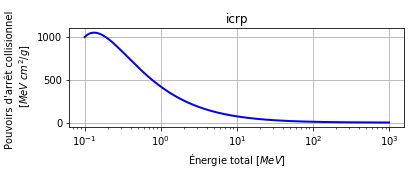

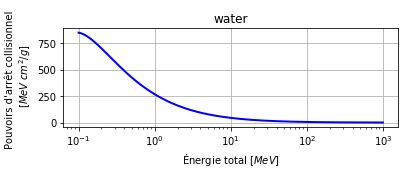

In [4]:
# We plot the Scol of the materials.

for material in materials:
    material.showScol()

Plotting the NIST Data for comparison

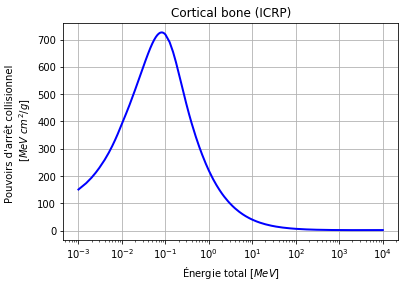

In [5]:
df_icrp = pandas.read_csv(f"{os.getcwd()}//Data/NIST_DATA_ICRP.txt", delimiter='|', header=2)
df_icrp = df_icrp.drop(columns=df_icrp.columns[-1])
data_icrp = df_icrp.to_numpy()


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(data_icrp[:, 0], data_icrp[:, 1], color='blue', lw=2)
ax.set_xscale('log')
ax.set_title("Cortical bone (ICRP)")
ax.set_xlabel("Énergie total [$MeV$]")
ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

plt.grid()
plt.show()

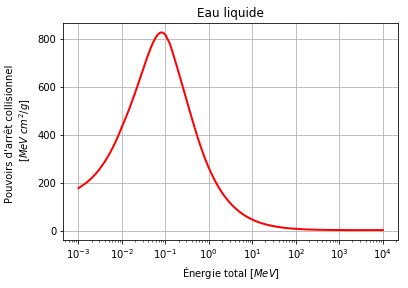

In [6]:
df_water = pandas.read_csv(f"{os.getcwd()}//Data/NIST_DATA_LIQUID_WATER.txt", delimiter='|', header=2)
df_water = df_water.drop(columns=df_water.columns[-1])
data_water = df_water.to_numpy()


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(data_water[:, 0], data_water[:, 1], color='red', lw=2)
ax.set_xscale('log')
ax.set_title("Eau liquide")
ax.set_xlabel("Énergie total [$MeV$]")
ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

plt.grid()
plt.show()

Les données semblent bien correspondent dans l'intervalle d'énergie $[3, \infty)$ MeV.

# Portée des protons dans la matière

## 3. Analyse dimensionnelle de R_CDSA

Voici l'équation:

$$R_{CSDA} = \int_{0}^{T_i} \frac{d T'}{S_{col}/\rho}$$

On peut voir sur le site du NIST que les unités de $R_{CSDA}$  sont des $[g/cm^2]$. À droite de l'équation, on intègre sur des MeV des 
$$\frac{[g/cm^3]}{[cm]^2 * [MeV] * [cm^{-3}]}$$
$$ = \frac{[g]}{[cm]^2 * [MeV]} $$

Ce qui nous donne les unités $[g/cm^2]$ à droite de l'équation, ce qui correspond bel et bien aux unités de $R_{CSDA}$.

## 4.

Comme on peut voir dans les graphique précédent (Il faudrait supperposer le graphique du modèle sur le graphique du NIST) les courbes correspondent. Montrer que la tendance des courbes sont bonnes et logique ainsi de comparer avec les données du NIST.

## 5. Justifiez la nécessité d’employer une méthode numérique pour calculer la portée des protons.

# Détermination de R_CSDA par intégration numérique

In [7]:
class MathFunction:
    
    """
    Class MathFunction permet la manipulation de fonction mathématique.
    """
    
    NforAdaptativeIntegration: dict = dict()
    
    def __init__(self, func):
        """
        Constructeur de la class MathFunction.
        :param func: Fontion mathématique. (Function or lambda expression)
        """
        self.function = func
        
        self.integration_methods: dict = {
            "auto": self.adaptative_trapezoid_integration,
            "trapezoid": self.trapezoid_integration,
            "adapdative_trapezoid": self.adaptative_trapezoid_integration
        }
    
    def __call__(self, *args):
        """
        Call de la fonction mathématique courante.
        :param args: arguments de la fonction courante.
        :return: return de self.function(*args)
        """
        return self.function(*args)
    
    def integrate(self, method: str = "auto", **kwargs):
        """
        Performe l'intégral de la fonction courante.
        :param method: La méthode d'intégration à utiliser. (str)
        :param kwargs: Arguments de la méthode d'intégration.
        
                      :bounds: Bornes de l'intégral définie ([float, float)
                      :N: Nombre de segment utilisé pour calculer l'intégral définie.
                      :error_target: L'erreur minimal requise. (float) default -> 1e-9
                      :max_iteration: Itération maximale utiliser pour trouver la précision demandé. (int)
        
        :return: L'intégrale définie de la fonction courante.
        """
        assert method in self.integration_methods
        return self.integration_methods[method](**kwargs)
    
    def findBestN_trapezoid_integration(self, **kwargs) -> (int, float):
        """
        Trouve le nombre de segment requis pour obtenir la précision demandé.
        :param kwargs: 
                      :bounds: Bornes de l'intégral définie ([float, float)
                      :error_target: L'erreur minimal requise. (float) default -> 1e-9
                      :max_iteration: Itération maximale utiliser pour trouver la précision demandé. (int)
        
        :return: N (int), erreur (float)
        """
        assert "bounds" in kwargs
        bounds = kwargs["bounds"]
        error_target = kwargs.get("error_target", 1e-9)
        max_iteration = kwargs.get("max_iteration", 1_000)
        
        memory: dict = {
            "I_i": self.trapezoid_integration(bounds=bounds, N=1),
            "I_i+1": self.trapezoid_integration(bounds=bounds, N=2)
        }
            
        bestN: int = 2
        
        error: float = np.inf
        for i in range(1, max_iteration+1):
            error = np.abs((memory["I_i+1"] - memory["I_i"])/3)
            if error <= error_target:
                break
            
            bestN = 2**(i+1)
            
            memory["I_i"] = memory["I_i+1"]
            memory["I_i+1"] = self.trapezoid_integration(bounds=bounds, N=bestN)
        
        self.NforAdaptativeIntegration["trapezoid"] = bestN
        
        return bestN, error
    
    def adaptative_trapezoid_integration(self, **kwargs) -> (float, float):
        """
        Performe l'intégrale définie avec la méthode des trapèzes toute en trouvant
         le meilleur nombre de segments à utiliser.
         
        :param kwargs: 
                      :bounds: Bornes de l'intégral définie ([float, float)
                      :error_target: L'erreur minimal requise. (float) default -> 1e-9
                      :max_iteration: Itération maximale utiliser pour trouver la précision demandé. (int)
                      
        :return: Intégral définie (float), erreur (float)
        """
        assert "bounds" in kwargs
        bounds = kwargs["bounds"]
        error_target = kwargs.get("error_target", 1e-9)
        max_iteration = kwargs.get("max_iteration", 100)
        
        memory: dict = {
            "I_i": self.trapezoid_integration(bounds=bounds, N=1),
            "I_i+1": self.trapezoid_integration(bounds=bounds, N=2)
        }
        
        error: float = np.inf
        for i in range(1, max_iteration+1):
            error = np.abs((memory["I_i+1"] - memory["I_i"])/3)
            if error <= error_target:
                break
            
            memory["I_i"] = memory["I_i+1"]
            memory["I_i+1"] = self.trapezoid_integration(bounds=bounds, N=2**(i+1))
            
        return memory["I_i+1"], error
    
    def trapezoid_integration(self, **kwargs) -> float:
        """
        Performe l'intégrale définie avec la méthode des trapèzes.
        :param kwargs: 
                      :bounds: Bornes de l'intégral définie ([float, float)
                      :N: Nombre de segment utilisé pour calculer l'intégral définie.
        :return: 
        """
        assert "bounds" in kwargs and "N" in kwargs
        bounds = kwargs["bounds"]
        N = kwargs["N"]
        
        X = np.linspace(bounds[0], bounds[1], N+1)
        Y = self(X)
        Y_d = Y[1:]
        Y_g = Y[:-1]
        h = (bounds[1] - bounds[0])/N
        return (h/2) * np.sum(Y_g + Y_d)

In [8]:
def MaterialNewInit(self, name: str, composition: dict = None, density: float = None,
                 mean_excitation_energy: float = None):
    """
        Constructeur de la class Material.
        
        :param name: Nom du matériel (str)
        :param composition: Dictionnaire comportant la composition du matériel
                            
                            composition: (dict) = {
                                Z_i: abondance relative i
                            }
                            
        :param density: Densité du matériel (float)
        :param mean_excitation_energy: Energie moyenne d'excitation du matériel [eV] (float)
    """
    
    self._name: str = name
    self._setCompositionAttribute(name, composition)
    self._setDensityAttribute(name, density)
    self._setMeanExcitationEnergyAttribute(name, mean_excitation_energy)  

    # Updating the Material _compostions
    if name not in Material._compositions:
        Material._compositions[name] = composition

    # Updating the Material _densities
    if name not in Material._densities:
        Material._densities[name] = density

    # Updating the Material _mean_excitation_energies
    if name not in Material._mean_excitation_energies:
        Material._mean_excitation_energies[name] = mean_excitation_energy
    
    # Intégrande de la fonction R_CSDA
    self.R_CSDA_integrand = MathFunction(lambda T: self.Density/self.getScol(T))

Material.__init__ = MaterialNewInit

def R_CSDA(self, bounds: [float, float] = [0.1, 100], integrationMethod="auto", **kwargs):
    """
    Calcule la portée dans l’approximation CSDA d'un proton donné.
    
    :param bounds: Bornes de l'intégral définie ([float, float)
    :param integrationMethod: La méthode d'intégration à utiliser. (str)
    :param kwargs: Arguments de la méthode d'intégration.
        
                      :bounds: Bornes de l'intégral définie ([float, float)
                      :N: Nombre de segment utilisé pour calculer l'intégral définie.
                      :error_target: L'erreur minimal requise. (float) default -> 1e-9
                      :max_iteration: Itération maximale utiliser pour trouver la précision demandé. (int)
    :return: La portée dans l’approximation CSDA (float)
    """
    return self.R_CSDA_integrand.integrate(method=integrationMethod, bounds=bounds, **kwargs)

Material.R_CSDA = R_CSDA  # Adding the R_CSDA function to Material class as a new method

In [9]:
icrp = Material(name="icrp")
water = Material(name="water")

icrp_Rcsda = icrp.R_CSDA(bounds=[0.1, 100])
water_Rcsda = water.R_CSDA(bounds=[0.1, 100])

print(f"Porté des protons dans le matériel '{icrp.Name}': {icrp_Rcsda[0]/icrp.Density} [cm], error: {icrp_Rcsda[1]} [cm]")
print(f"Porté des protons dans le matériel '{water.Name}': {water_Rcsda[0]/water.Density} [cm], error: {water_Rcsda[1]} [cm]")

Porté des protons dans le matériel 'icrp': 4.6621300281730855 [cm], error: 4.1185603076125216e-10 [cm]
Porté des protons dans le matériel 'water': 7.710811065633429 [cm], error: 8.799769801726143e-10 [cm]


## 7. 


$$  $$

## 9.

On va faire l'implémentation de Newman de la quadrature gaussienne.

In [10]:
def gaussxq(self, N) -> (float, float):
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3,4*N-1,N)/(4*N+2)
    x = np.cos(np.pi*a+1/(8*(N**2)*np.tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta > epsilon:
        p0 = np.ones(N,float)
        p1 = np.copy(x)
        for k in range(1,N):
            p0, p1 = p1, ((2*k+1)*x*p1-k*p0)/(k+1)
        
        dp = (N+1)*(p0-x*p1)/(1-x**2)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2*((N+1)**2)/((N**2)*(1-x**2)*(dp**2))

    return x, w

MathFunction.gaussxq = gaussxq

MathFunction.gaussxqValuesForN = dict()

def gaussian_quadrature_integration(self, **kwargs) -> float:
    # P.170 Computational physics
    assert "bounds" in kwargs and "N" in kwargs
    bounds = kwargs["bounds"]
    N = kwargs["N"]
    [a, b] = bounds
    
    # Calculate the sample points ans weights, then map them
    # to the required integration domain
    if N in MathFunction.gaussxqValuesForN:
        x, w = MathFunction.gaussxqValuesForN[N]
    else:
        x, w = self.gaussxq(N)
        MathFunction.gaussxqValuesForN[N] = (x, w)
    
    xp = 0.5*(b-a)*x + 0.5*(b+a)
    wp = 0.5*(b-a)*w
    
    # perform the integration
    # s = np.sum([wp[k]*self.function(xp[k]) for k in range(N)])
    s = np.sum(wp*self.function(xp))
    return s

MathFunction.gaussian_quadrature_integration = gaussian_quadrature_integration

def gaussian_quad_find_N(self, **kwargs) -> (int, float):
    assert "bounds" in kwargs
    bounds = kwargs["bounds"]
    error_target = kwargs.get("error_target", 1e-9)
    max_iteration = kwargs.get("max_iteration", 100)

    memory: dict = {
        "I_i": self.gaussian_quadrature_integration(bounds=bounds, N=1),
        "I_i+1": self.gaussian_quadrature_integration(bounds=bounds, N=2)
    }

    bestN: int = 2

    error: float = np.inf
    for i in range(1, max_iteration+1):
        error = np.abs(memory["I_i+1"] - memory["I_i"])
        if error <= error_target:
            break

        bestN = 2**(i+1)

        memory["I_i"] = memory["I_i+1"]
        memory["I_i+1"] = self.gaussian_quadrature_integration(bounds=bounds, N=bestN)

    return bestN, error

MathFunction.gaussian_quad_find_N = gaussian_quad_find_N

def adaptative_gaussian_quadrature(self, **kwargs) -> (float, float):
    assert "bounds" in kwargs
    N, error = self.gaussian_quad_find_N(**kwargs)
    kwargs["N"] = N
    return self.gaussian_quadrature_integration(**kwargs), error

MathFunction.adaptative_gaussian_quadrature = adaptative_gaussian_quadrature

def newMathFunctionInit(self, func):
    self.function = func

    self.integration_methods: dict = {
        "auto": self.adaptative_gaussian_quadrature,
        "trapezoid": self.trapezoid_integration,
        "adapdative_trapezoid": self.adaptative_trapezoid_integration,
        "adaptative_gaussian_quadrature": self.adaptative_gaussian_quadrature,
        "gaussian_quadrature_integration": self.gaussian_quadrature_integration
    }

MathFunction.__init__ = newMathFunctionInit

Maintenant, nous allons afficher l'histograme de la portée des protons dans l'eau pour 10 000 protons ayant une énergies aléatoirement distribué de façon normale.

In [11]:
water = Material(name="water")
proton_energies = np.random.normal(240, 3, 10_000)

gaussN, gaussError = water.R_CSDA_integrand.gaussian_quad_find_N(bounds=[0.1, 240], error_target=1e-9)

proton_ranges = [water.R_CSDA(bounds=[0.1, e], integrationMethod="gaussian_quadrature_integration", N=gaussN) for e in proton_energies]

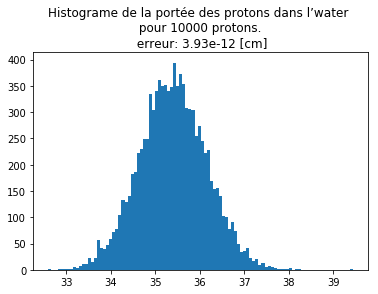

In [12]:
plt.hist(proton_ranges, bins=100)
plt.title(f"Histograme de la portée des protons dans l’{water.Name} \n pour {len(proton_ranges)} protons. "
          f"\n erreur: {gaussError:.2e} [cm]")
plt.show()

Ici, on test le temps d'exécution de notre méthode *R_CSDA* à l'aide du module timeit. Nous allosn lancer 10 000 exécutions pour simuler 10 000 protons, compter le temps requis et trouver le temps d'exécution moyen pour un proton.

In [13]:
def integrationMethodTimeTester(integrationMethod, material, n_protons: int = 10_000, **kwargs):
    shootProtonInMaterial = lambda: material.R_CSDA(bounds=[0.1, np.random.normal(240, 3, 1)], integrationMethod=integrationMethod, N=kwargs.get('N'))

    total_execution_time = timeit.timeit(shootProtonInMaterial, number=n_protons)
    mean_execution_time = total_execution_time/n_protons

    print(f"Moyenne d'exécution pour un proton avec la methode {integrationMethod}: {mean_execution_time:.3e} s")

In [14]:
integrationMethodTimeTester("gaussian_quadrature_integration", Material(name="water"), N=gaussN)

Moyenne d'exécution pour un proton avec la methode gaussian_quadrature_integration: 2.059e-04 s


# 10. On test *trapezoid*

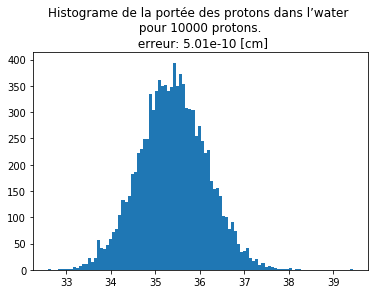

Moyenne d'exécution pour un proton avec la methode trapezoid: 3.976e-03 s


In [15]:
trapN, trapError = water.R_CSDA_integrand.findBestN_trapezoid_integration(bounds=[0.1, 240], error_target=1e-9)
proton_ranges = [water.R_CSDA(bounds=[0.1, e], integrationMethod="trapezoid", N=trapN) for e in proton_energies]
plt.hist(proton_ranges, bins=100)
plt.title(f"Histograme de la portée des protons dans l’{water.Name} \n pour {len(proton_ranges)} protons. "
          f"\n erreur: {trapError:.2e} [cm]")
plt.show()

integrationMethodTimeTester("trapezoid", Material(name="water"), N=trapN)

# 11. On test *scipy.integrate.quad*

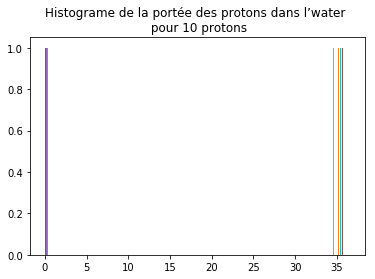

Moyenne d'exécution pour un proton avec la methode scipy.integrate.quad: 5.127e-03 s


In [16]:
import scipy.integrate as scipyIntegration

integrand = lambda T: water.Density/water.getScol(T)
scipy_R_CSDA = lambda e: scipyIntegration.quad(integrand, 0.1, e)

proton_energies = np.random.normal(240, 3, 10)
proton_ranges = [scipy_R_CSDA(e) for e in proton_energies]

plt.hist(proton_ranges, bins=100)
plt.title(f"Histograme de la portée des protons dans l’{water.Name} \n pour {len(proton_ranges)} protons")
plt.show()

shootProtonInMaterial = lambda: scipyIntegration.quad(integrand, 0.1, np.random.normal(240, 3, 1))
total_execution_time = timeit.timeit(shootProtonInMaterial, number=len(proton_ranges))
mean_execution_time = total_execution_time/len(proton_ranges)

print(f"Moyenne d'exécution pour un proton avec la methode scipy.integrate.quad: {mean_execution_time:.3e} s")

Ici, on explique ce que fait en détail *scipy.integrate.quad*

# 13.

On construit la nouvelle méthode pour calculer l'énergie déposé des protons dans un milieu.

In [17]:
def MaterialNewInit(self, name: str, composition: dict = None, density: float = None,
                 mean_excitation_energy: float = None):
    
    self._name: str = name
    self._setCompositionAttribute(name, composition)
    self._setDensityAttribute(name, density)
    self._setMeanExcitationEnergyAttribute(name, mean_excitation_energy)

    # Updating the Material _compostions
    if name not in Material._compositions:
        Material._compositions[name] = composition

    # Updating the Material _densities
    if name not in Material._densities:
        Material._densities[name] = density

    # Updating the Material _mean_excitation_energies
    if name not in Material._mean_excitation_energies:
        Material._mean_excitation_energies[name] = mean_excitation_energy
    
    self.R_CSDA_integrand = MathFunction(lambda T: self.Density/self.getScol(T))
    self.displacementStep_integrand = MathFunction(lambda T: 1/self.getScol(T))
    
Material.__init__ = MaterialNewInit

def getDisplacementStep(self, bounds: [float, float] = [0, 100], integrationMethod="auto", **kwargs):
    return self.displacementStep_integrand.integrate(method=integrationMethod, bounds=bounds, **kwargs)

Material.getDisplacementStep = getDisplacementStep

def showDepositEnergyByDepth(self, proton_initial_energy, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    T = np.linspace(0, proton_initial_energy, 10)

    line, = ax.plot([self.getDisplacementStep(bounds=[0.1, e], **kwargs) for e in T], T, color='blue', lw=2)
    ax.set_title(f"Proton de {proton_initial_energy} MeV dans le matériel: {self.Name}")
    ax.set_xlabel(f"Profondeur de {self.Name} [cm]")
    ax.set_ylabel(f"Dépôt d’énergie [MeV]")

    plt.grid()
    plt.show()

Material.showDepositEnergyByDepth = showDepositEnergyByDepth

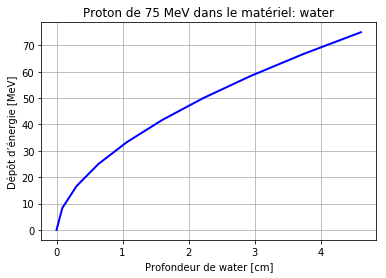

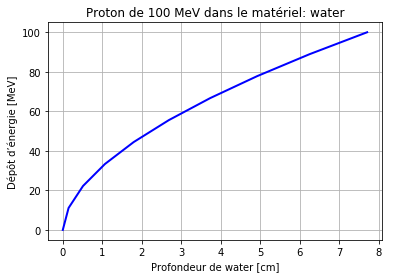

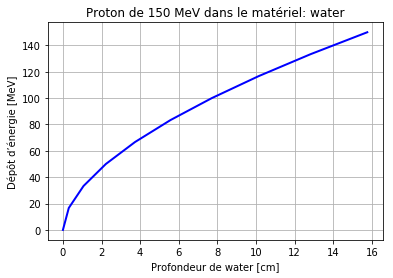

In [18]:
proton_inital_energies: np.ndarray = np.array([75, 100, 150])  # MeV

icrp = Material(name="icrp")
water = Material(name="water")
for e in proton_inital_energies:
    gaussN, gaussError = water.R_CSDA_integrand.gaussian_quad_find_N(bounds=[0.1, e], error_target=1e-9)
    water.showDepositEnergyByDepth(e, integrationMethod="gaussian_quadrature_integration", N=gaussN)



# 14.
Il devient beaucoup plus avantageux d'utiliser 
la thérapie au proton lorsque la tumeur cible est localisée
dans un millieu critique du corps tel que le cerveau. Puisque 
le proton dépose la majorité de son énergie dans une très petite zone 
autour de la position d'arrêt complet, celui-ci dépose donc moins 
d'énergie dans les tissus environnants qu'un photon. Ce qui 
implique donc que le dépot de dose est plus localisé que dans le cas 
d'une thérapie classic aux photons, ce qui par le même fait 
réduit les dommages engendrés aux tissus envirronnants. Cet avantage
devient critique dans le cas d'une tumeur au cerveau puisque l'objectif 
d'engendrer un minimum de dommages cerébraux.

